In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from decimal import Decimal

from sales_model_data import SalesModelData

import optuna
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from catboost import Pool

# import tensorflow as tf

from sales_model_func import (
    get_train_test_data,
    train_default_XGBRegressor,
    train_default_LGBMRegressor,
    train_default_CatBoost,
    train_xgboost,
    train_lgbm,
    train_catboost,
    generate_binary_combinations,
    create_example_data_with_features,
    models_analysis_table,
    select_top_model_vec,
    calculate_low_up_bounds
)

from sales_model_func import (
    compare_with_dummy_model,
    compare_trpred_periods,
    plot_predictions,
    plot_differences_in_predictions,
    count_points_diff,
    calculate_confidence_inteval
)


In [ ]:
all_models_parametrs = pd.DataFrame(
    index=['XGBoost', 'LGBM', 'CatBoost', 'Ensabmle(XGB/LGB)', 'Ensabmle(All)', 'Ensabmle(XGB/LGB)_weighted', 'Ensabmle(All)_weighted'],
    columns=['MSE_crossval', 'MSE_test', 'Accuracy', 'mean_accuracy', 'best_params', 'features_vec'])

In [ ]:
df = SalesModelData()
df = df.get_data(period=True, translit=True, left_lim='2023-01-01', right_lim='2024-09-30')
# df_individual = df.query('companyType == "individual"').reset_index(drop=True).copy()
# df_legal = df.query('companyType == "legal"').reset_index(drop=True).copy()
print(f'df size: rows {len(df)} columns {len(df.columns)}')

df size: rows 26890 columns 21


In [ ]:
VALIDATION_SIZE = 15+1
TEST_SIZE = 15
GAP = 5
CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP, TEST_SIZE+60+GAP, TEST_SIZE+90+GAP]
# CROSVAL_LIST = [TEST_SIZE+GAP, 
#                 TEST_SIZE+15+GAP, 
#                 TEST_SIZE+30+GAP, 
#                 TEST_SIZE+45+GAP, 
#                 TEST_SIZE+60+GAP, 
#                 TEST_SIZE+75+GAP, 
#                 TEST_SIZE+90+GAP,
#                 TEST_SIZE+105+GAP,
#                 TEST_SIZE+120+GAP,
#                 TEST_SIZE+135+GAP]
CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP]
CHUNKS = len(CROSVAL_LIST)
FEATURES_BLOCKS_QUANTITY_XGBOOST = 5 #cant be more then 7
FEATURES_BLOCKS_QUANTITY_LGBM = 1
FEATURES_BLOCKS_QUANTITY_CATBOOST = 1

In [ ]:
assert FEATURES_BLOCKS_QUANTITY_XGBOOST <=7, f'FEATURES_BLOCKS_QUANTITY_XGBOOST can not be more then evalible feature block quantity - 7'
assert FEATURES_BLOCKS_QUANTITY_LGBM <=7, f'FEATURES_BLOCKS_QUANTITY_LGBM can not be more then evalible feature block quantity - 7'
assert FEATURES_BLOCKS_QUANTITY_CATBOOST <=7, f'FEATURES_BLOCKS_QUANTITY_CATBOOST can not be more then evalible feature block quantity - 7'

In [ ]:
margin_of_error_list = []

XGB train
----------

In [ ]:
parametrs = []
comb_len = FEATURES_BLOCKS_QUANTITY_XGBOOST #this number less or equal len(all_features_dict) in def create_example_data_with_features
feature_test_size = 'min' if comb_len <= 4 else 'all'
comb_count = 2**comb_len
verbose = True

for i, combination in enumerate(generate_binary_combinations(comb_len)):
    if verbose:
        print(f'Step {i+1}/{comb_count}', end="\r")
    data, params, model_params_number = create_example_data_with_features(df, combination, feature_test_size=feature_test_size)

    start_time = time.time() 
    mse, _ = train_xgboost(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST)
    end_time = time.time()
    execution_time = round((end_time - start_time), 3)
    
    params.extend([execution_time]) #index -3
    params.extend([model_params_number]) #index -2
    params.extend([mse]) #index -1
    parametrs.append(params)

Nothing new to merge


In [ ]:
xgboost_resulst = models_analysis_table(parametrs)
print(f'Worst MSE {xgboost_resulst.MSE.max()}')
print(f'Best  MSE {xgboost_resulst.MSE.min()}')
print(f'Worst time {xgboost_resulst.fit_time.max()} seconds')
print(f'Best  time {xgboost_resulst.fit_time.min()} seconds')
xgboost_resulst.sort_values(by='MSE', ascending=True).head(20)

Worst MSE 597975098318.9163
Best  MSE 330559967295.25464
Worst time 20.217 seconds
Best  time 0.116 seconds


/home/konst/Giardino/sales_model_func.py:209: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  models_dataframe = pd.concat([models_dataframe, models_row], ignore_index=True)


,set_data_augmentation,set_goods_features,set_agents_features,set_lag_features,set_rolling_average_features,MSE,params_num,fit_time
0,0,0,1,0,1,3.305600e+11,7113,14.739
1,0,0,1,1,1,3.309742e+11,7117,12.992
2,1,0,1,0,1,3.487650e+11,8534,16.453
3,1,0,1,1,1,3.827126e+11,8538,15.174
4,0,0,1,1,0,3.912853e+11,7106,14.642
5,1,1,1,0,0,4.037242e+11,8930,17.363
6,0,0,1,0,0,4.061480e+11,7102,14.377
7,1,0,1,0,0,4.124563e+11,8523,18.752
8,1,0,1,1,0,4.132159e+11,8527,15.837
9,1,1,1,0,1,4.298619e+11,8941,18.720


In [ ]:
xgb_comb_vec, features_xbg_dict_size = select_top_model_vec(xgboost_resulst, top_mse = 3, top_fit_time = 1)
all_models_parametrs.loc['XGBoost','features_vec'] = str(xgb_comb_vec)
xgb_comb_vec

['1', '1', '0', '0', '0']

In [ ]:
data, _, _ = create_example_data_with_features(df, xgb_comb_vec, feature_test_size=features_xbg_dict_size)
train_data_day = data.copy()

X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_data_day, test_size=TEST_SIZE+1)
mse_day, _, _ = train_default_XGBRegressor(X_train, X_test, y_day_train, y_day_test)
print(f'MSE default_XGBRegressor day prediction: {mse_day}')

MSE default_XGBRegressor day prediction: 8820343694231.652


In [ ]:
data.head(10)

,created_day,created_week_1,created_month_2,created_year_3,day_4,sum,Aromadiffuzor_Amber_dream_(100_ml)_6,Aromadiffuzor_Amber_dream_(500_ml)_7,Aromadiffuzor_Ambre_dream_(100_ml)_8,Aromadiffuzor_Ambre_dream_(500_ml)_9,...,Shampun_dlya_normalnyh_volos_Grapefruit_&_Santal_(5000_ml)_403,Shampun_dlya_normalnyh_volos_Jasmine_&_Cassis_(250_ml)_404,Shampun_dlya_normalnyh_volos_Jasmine_&_Cassis_(500_ml)_405,Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(250_ml)_406,Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(500_ml)_407,Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(5000_ml)_408,Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(50_ml)_409,Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(500_ml)_410,Shampun_dlya_normalnyh_volos_bessulfatnyy_Grapefruit_&_Santal_(50_ml)_411,Shampun_dlya_normalnyh_volos_bessulfatnyy_Oud_&_Black_pepper_(50_ml)_412
0,2022-12-01,48,12,2022,1,9.604800e+04,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-12-02,48,12,2022,2,8.160600e+04,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-12-03,48,12,2022,3,2.153600e+04,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-12-04,48,12,2022,4,7.961900e+05,2,1,0,0,...,0,0,0,0,0,0,0,3,0,0
4,2022-12-05,49,12,2022,5,8.565990e+05,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,2022-12-06,49,12,2022,6,1.446644e+06,8,0,0,0,...,0,0,0,0,1,0,0,6,0,1
6,2022-12-07,49,12,2022,7,4.236696e+05,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2022-12-08,49,12,2022,8,2.651430e+05,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2022-12-09,49,12,2022,9,1.995700e+04,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2022-12-10,49,12,2022,10,1.596666e+05,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def objective(trial, data):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
    }
    
    mse, _ = train_xgboost(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST, params=params)
    return -mse  # Optuna максимизирует, поэтому возвращаем отрицательное MSE

data, _, _ = create_example_data_with_features(df, xgb_comb_vec, feature_test_size=features_xbg_dict_size)

# Создаем исследование Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, data), n_trials=3)

# Получаем наилучшие параметры и результат
best_params = study.best_params
best_score = -study.best_value  # Переводим обратно в MSE
best_xgb_params = best_params.copy()
best_val_xgb_mse = best_score

print("Лучшие параметры:", best_params)
all_models_parametrs.loc['XGBoost','best_params'] = str(best_params)
all_models_parametrs.loc['XGBoost','MSE_crossval'] = '%.2E' % Decimal(best_val_xgb_mse)
print("Лучший результат XGB VAL (MSE):", '%.2E' % Decimal(best_score))

[I 2024-05-08 02:02:38,137] A new study created in memory with name: no-name-ade5653c-5b3b-4a8a-956b-7ecd98f79aa8
[I 2024-05-08 02:02:42,705] Trial 0 finished with value: -476347405736.6371 and parameters: {'max_depth': 2, 'learning_rate': 0.017249806204768327, 'n_estimators': 191, 'gamma': 0.11624409423766482, 'subsample': 0.9660423919854036, 'colsample_bytree': 0.9164302789548944, 'reg_alpha': 0.2824998186349917, 'reg_lambda': 0.19299848708402412}. Best is trial 0 with value: -476347405736.6371.
[I 2024-05-08 02:02:45,641] Trial 1 finished with value: -442932819628.2626 and parameters: {'max_depth': 2, 'learning_rate': 0.17908634002759577, 'n_estimators': 73, 'gamma': 0.02218936599414292, 'subsample': 0.8848208448432091, 'colsample_bytree': 0.9419650317786733, 'reg_alpha': 0.1876234365431258, 'reg_lambda': 0.9214893335788501}. Best is trial 1 with value: -442932819628.2626.
[I 2024-05-08 02:02:49,982] Trial 2 finished with value: -403529351214.28064 and parameters: {'max_depth': 3, '

Лучшие параметры: {'max_depth': 3, 'learning_rate': 0.2462442109726735, 'n_estimators': 160, 'gamma': 0.08156813191119115, 'subsample': 0.8814263200477946, 'colsample_bytree': 0.8472374014961873, 'reg_alpha': 0.017045260388027006, 'reg_lambda': 0.9489629757598417}
Лучший результат XGB VAL (MSE): 4.04E+11


In [ ]:
_, margin_of_error = train_xgboost(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST, params=best_xgb_params)

In [ ]:
# Оценка модели
mse_day, y_pred_xgb, best_xgb_model_day = train_default_XGBRegressor(X_train, X_test, y_day_train, y_day_test, params=best_xgb_params)
all_models_parametrs.loc['XGBoost','MSE_test'] = '%.2E' % Decimal(mse_day)
print(f'MSE for day prediction with best XGB model: {mse_day}')

MSE for day prediction with best XGB model: 8533409364912.376


MODEL IS OK


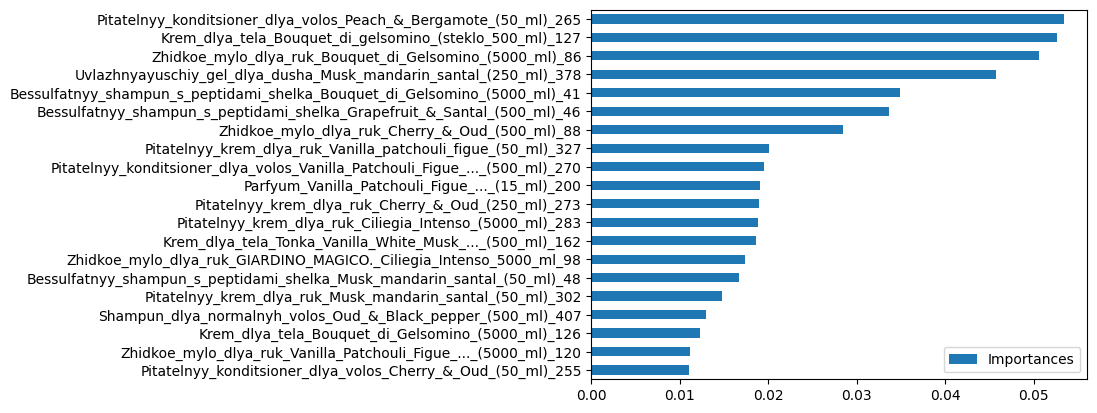

In [ ]:
fi = pd.DataFrame(data=best_xgb_model_day.feature_importances_, index=best_xgb_model_day.feature_names_in_, columns=['Importances'])
fi.sort_values('Importances', ascending=True)[-20:].plot(kind='barh')
compare_with_dummy_model(y_train=y_day_train,
                         y_test=y_day_test,
                         y_pred=y_pred_xgb, 
                         model_mse=mse_day,)

In [ ]:
lower_bound, upper_bound = calculate_low_up_bounds(y_pred_xgb, margin_of_error, y_day_test.index)
margin_of_error_list.append(margin_of_error)

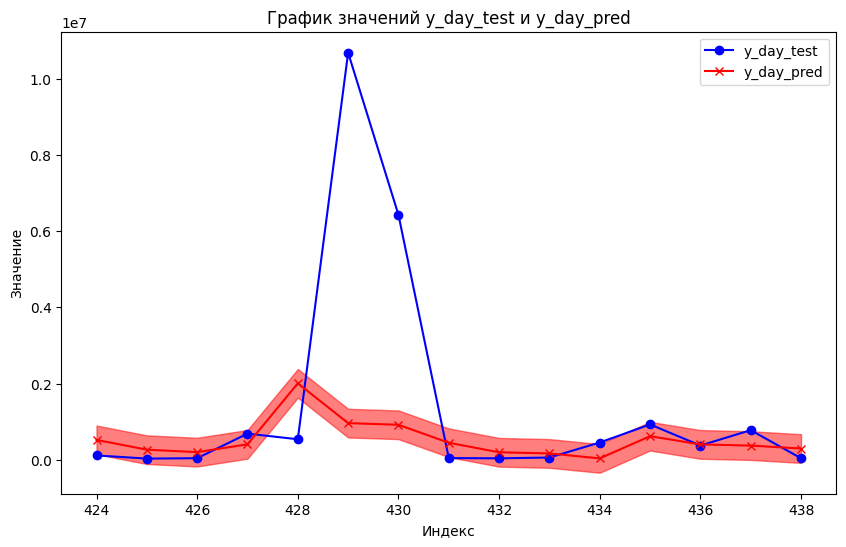

Фактические продажи ниже lower_bound 3, 20.00%
Фактические продажи выше upper_bound 4, 26.67%
Фактические продажи в рамках границ прогнозов 8, 53.33%


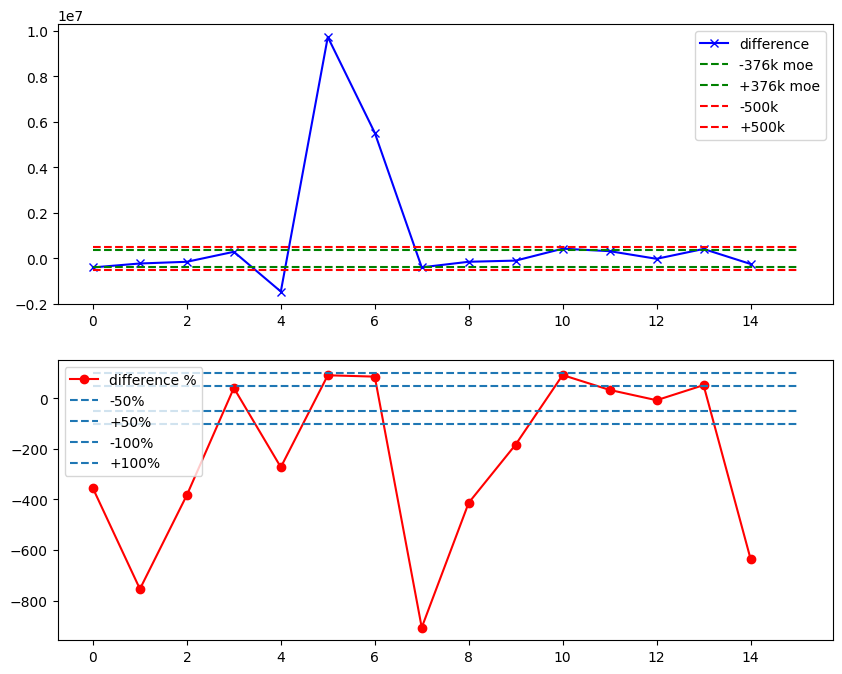

In [ ]:
plot_predictions(y_pred=y_pred_xgb,
                y_test=y_day_test,
                lower_bound=lower_bound,
                upper_bound=upper_bound)
plot_differences_in_predictions(y_pred=y_pred_xgb, 
                                y_test=y_day_test,
                                margin_of_error=margin_of_error)

In [ ]:
acc, mean_acc = compare_trpred_periods(y_test=y_day_test,
                       y_pred=y_pred_xgb,
                       periods=[7, 14, 30, 45])
all_models_parametrs.loc['XGBoost','Accuracy'] = round(acc,2)
all_models_parametrs.loc['XGBoost','mean_accuracy'] = round(mean_acc,2)
count_points_diff(y_test=y_day_test,
                  y_pred=y_pred_xgb,
                  points = [10, 25, 50, 100, 200])

Revenue for last 7 days was 18566149.00
Predicted revenue 5727342.78
Difference: 12838806.22 69.15%
----------------------
Revenue for last 14 days was 21235491.00
Predicted revenue 7817785.05
Difference: 13417705.95 63.19%
----------------------
#####
#####
Total fact sales = 21235491.0
Total pred sales = 7817785.5
Total fact sales minus total pred sales = 13417705.50
Total Accuracy score: 36.81%
Mean accuracy (on each point) -186.84%
----------------------
Всего точек для прогноза 15
В результатах прогноза 14 точек имеют разницу с фактов более 10%
В результатах прогноза 14 точек имеют разницу с фактов более 25%
В результатах прогноза 12 точек имеют разницу с фактов более 50%
В результатах прогноза 8 точек имеют разницу с фактов более 100%
В результатах прогноза 7 точек имеют разницу с фактов более 200%


In [ ]:
all_models_parametrs

,MSE_crossval,MSE_test,Accuracy,mean_accuracy,best_params,features_vec
XGBoost,4.04E+11,8.53E+12,36.81,-186.84,"{'max_depth': 3, 'learning_rate': 0.2462442109...","['1', '1', '0', '0', '0']"
LGBM,NaN,NaN,NaN,NaN,NaN,NaN
CatBoost,NaN,NaN,NaN,NaN,NaN,NaN
Ensabmle(XGB/LGB),NaN,NaN,NaN,NaN,NaN,NaN
Ensabmle(All),NaN,NaN,NaN,NaN,NaN,NaN
Ensabmle(XGB/LGB)_weighted,NaN,NaN,NaN,NaN,NaN,NaN
Ensabmle(All)_weighted,NaN,NaN,NaN,NaN,NaN,NaN


LGBM train
----------

In [ ]:
parametrs = []
comb_len = FEATURES_BLOCKS_QUANTITY_LGBM #this number less or equal len(all_features_dict) in def create_example_data_with_features
feature_test_size = 'min' if comb_len <= 4 else 'all'
comb_count = 2**comb_len
verbose = True

for i, combination in enumerate(generate_binary_combinations(comb_len)):
    if verbose:
        print(f'Step {i+1}/{comb_count}', end="\r")
    data, params, model_params_number = create_example_data_with_features(df, combination, feature_test_size=feature_test_size)

    start_time = time.time() 
    mse, _ = train_lgbm(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST)
    end_time = time.time()
    execution_time = round((end_time - start_time), 3)
    
    params.extend([execution_time]) #index -3
    params.extend([model_params_number]) #index -2
    params.extend([mse]) #index -1
    parametrs.append(params)

In [ ]:
lgbm_resulst = models_analysis_table(parametrs)
print(f'Worst MSE {lgbm_resulst.MSE.max()}')
print(f'Best  MSE {lgbm_resulst.MSE.min()}')
print(f'Worst time {lgbm_resulst.fit_time.max()} seconds')
print(f'Best  time {lgbm_resulst.fit_time.min()} seconds')
lgbm_resulst.sort_values(by='MSE', ascending=True).head(20)

In [ ]:
lgbm_comb_vec, features_lgbm_dict_size = select_top_model_vec(lgbm_resulst, top_mse = 3, top_fit_time = 1)
all_models_parametrs.loc['LGBM','features_vec'] = str(lgbm_comb_vec)
lgbm_comb_vec

In [ ]:
data, _, _ = create_example_data_with_features(df, lgbm_comb_vec, feature_test_size=features_lgbm_dict_size)
train_data_day = data.copy()

X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_data_day, test_size=TEST_SIZE+1)
mse_day, _, _ = train_default_LGBMRegressor(X_train, X_test, y_day_train, y_day_test)
print(f'MSE default_LGBMRegressor prediction: {mse_day}')

In [ ]:
def objective(trial, data):
    # Определяем пространство поиска для параметров
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 3, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
    }

    mse, _ = train_lgbm(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST, params=params)
    return -mse  # Optuna максимизирует, поэтому возвращаем отрицательное MSE

data, _, _ = create_example_data_with_features(df, lgbm_comb_vec, feature_test_size=features_lgbm_dict_size)
data = data.copy()

# Создаем исследование Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, data), n_trials=100)

# Получаем наилучшие параметры и результат
best_params = study.best_params
best_score = -study.best_value  # Переводим обратно в MSE
best_lgmb_params = best_params.copy()
best_val_lgbm_mse = best_score

print("Лучшие параметры:", best_params)
all_models_parametrs.loc['LGBM','best_params'] = str(best_params)
all_models_parametrs.loc['LGBM','MSE_crossval'] = '%.2E' % Decimal(best_score)
print("Лучший результат LGBM VAL (MSE):", '%.2E' % Decimal(best_score))

In [ ]:
_, margin_of_error = train_lgbm(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST, params=best_lgmb_params)

In [ ]:
# Оценка модели
mse_day, y_pred_lgbm_best, best_lightgbm_model_day = train_default_LGBMRegressor(X_train, X_test, y_day_train, y_day_test, params=best_lgmb_params)
all_models_parametrs.loc['LGBM','MSE_test'] = '%.2E' % Decimal(mse_day)
print(f'MSE for day prediction with best LGBM model: {mse_day}')

In [ ]:
# Plot feature importance using Split
lgb.plot_importance(best_lightgbm_model_day, importance_type="gain", figsize=(7,6), max_num_features=20, title="LightGBM Feature Importance (Gain)")
lgb.plot_importance(best_lightgbm_model_day, importance_type="split", figsize=(7,6), max_num_features=20, title="LightGBM Feature Importance (Split)")
plt.show()
compare_with_dummy_model(y_train=y_day_train,
                         y_test=y_day_test,
                         y_pred=y_pred_lgbm_best, 
                         model_mse=mse_day)


In [ ]:
lower_bound, upper_bound = calculate_low_up_bounds(y_pred_lgbm_best, margin_of_error, y_day_test.index)
margin_of_error_list.append(margin_of_error)

In [ ]:
plot_predictions(y_pred=y_pred_lgbm_best,
                y_test=y_day_test,
                lower_bound=lower_bound,
                upper_bound=upper_bound)
plot_differences_in_predictions(y_pred=y_pred_lgbm_best, 
                                y_test=y_day_test,
                                margin_of_error=margin_of_error)

In [ ]:
acc, mean_acc = compare_trpred_periods(y_test=y_day_test,
                       y_pred=y_pred_lgbm_best,
                       periods=[7, 14, 30, 45])
all_models_parametrs.loc['LGBM','Accuracy'] = round(acc,2)
all_models_parametrs.loc['LGBM','mean_accuracy'] = round(mean_acc,2)
count_points_diff(y_test=y_day_test,
                  y_pred=y_pred_lgbm_best,
                  points = [5, 10, 15, 25, 50, 75, 100, 200])

CatBoost train
--------

In [ ]:
parametrs = []
comb_len = FEATURES_BLOCKS_QUANTITY_CATBOOST #this number less or equal len(all_features_dict) in def create_example_data_with_features
feature_test_size = 'min' if comb_len <= 4 else 'all'
comb_count = 2**comb_len
verbose = True

for i, combination in enumerate(generate_binary_combinations(comb_len)):
    if verbose:
        print(f'Step {i+1}/{comb_count}', end="\r")
    data, params, model_params_number = create_example_data_with_features(df, combination, feature_test_size=feature_test_size)

    start_time = time.time() 
    mse, _ = train_catboost(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST)
    end_time = time.time()
    execution_time = round((end_time - start_time), 3)
    
    params.extend([execution_time]) #index -3
    params.extend([model_params_number]) #index -2
    params.extend([mse]) #index -1
    parametrs.append(params)

In [ ]:
catboost_resulst = models_analysis_table(parametrs)
print(f'Worst MSE {catboost_resulst.MSE.max()}')
print(f'Best  MSE {catboost_resulst.MSE.min()}')
print(f'Worst time {catboost_resulst.fit_time.max()} seconds')
print(f'Best  time {catboost_resulst.fit_time.min()} seconds')
catboost_resulst.sort_values(by='MSE', ascending=True).head(20)

In [ ]:
catb_comb_vec, features_catb_dict_size = select_top_model_vec(catboost_resulst, top_mse = 3, top_fit_time = 1)
all_models_parametrs.loc['CatBoost','features_vec'] = str(catb_comb_vec)
lgbm_comb_vec

In [ ]:
data, _, _ = create_example_data_with_features(df, catb_comb_vec, feature_test_size=features_catb_dict_size)
train_data_day = data.copy()

X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_data_day, test_size=TEST_SIZE+1)
mse_day, _, _ = train_default_CatBoost(X_train, X_test, y_day_train, y_day_test)
print(f'MSE default_CatBoost prediction: {mse_day}')

In [ ]:
def objective(trial, data):
    # Определяем пространство поиска для параметров
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
    }

    mse, _ = train_catboost(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST, params=params)
    return -mse
    

data, _, _ = create_example_data_with_features(df, catb_comb_vec, feature_test_size=features_catb_dict_size)
data = data.copy()

# Создаем исследование Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, data), n_trials=100)

# Получаем наилучшие параметры и результат
best_params = study.best_params
best_score = -study.best_value  # Переводим обратно в MSE
best_catb_params = best_params.copy()
best_val_catb_mse = best_score

print("Лучшие параметры:", best_params)
all_models_parametrs.loc['CatBoost','best_params'] = str(best_params)
all_models_parametrs.loc['CatBoost','MSE_crossval'] = '%.2E' % Decimal(best_score)
print("Лучший результат CatBoost Val (MSE):", '%.2E' % Decimal(best_score))

In [ ]:
_, margin_of_error = train_catboost(data, cross_validation=True, chunks=CHUNKS, validation_size=VALIDATION_SIZE, cv_offset_list = CROSVAL_LIST, params=best_catb_params)

In [ ]:
mse_day, y_pred_catboost, best_catboost_model_day = train_default_CatBoost(X_train, X_test, y_day_train, y_day_test, params=best_catb_params)
all_models_parametrs.loc['CatBoost','MSE_test'] = '%.2E' % Decimal(mse_day)
print(f'MSE for day prediction with best CatBoost model: {mse_day}')

In [ ]:
# Plot feature importance using Split
feature_importance = best_catboost_model_day.get_feature_importance(Pool(X_train, y_day_train))
feature_names = X_train.columns
fi = pd.DataFrame(data=feature_importance, index=feature_names, columns=['Importances'])
fi.sort_values('Importances', ascending=True)[-20:].plot(kind='barh')

compare_with_dummy_model(y_train=y_day_train,
                         y_test=y_day_test,
                         y_pred=y_pred_catboost, 
                         model_mse=mse_day)

In [ ]:
lower_bound, upper_bound = calculate_low_up_bounds(y_pred_catboost, margin_of_error, y_day_test.index)
margin_of_error_list.append(margin_of_error)

In [ ]:
plot_predictions(y_pred=y_pred_catboost,
                y_test=y_day_test,
                lower_bound=lower_bound,
                upper_bound=upper_bound)
plot_differences_in_predictions(y_pred=y_pred_catboost, 
                                y_test=y_day_test,
                                margin_of_error=margin_of_error)

In [ ]:
acc, mean_acc = compare_trpred_periods(y_test=y_day_test,
                       y_pred=y_pred_catboost,
                       periods=[7, 14, 30, 45])
all_models_parametrs.loc['CatBoost','Accuracy'] = round(acc,2)
all_models_parametrs.loc['CatBoost','mean_accuracy'] = round(mean_acc,2)
count_points_diff(y_test=y_day_test,
                  y_pred=y_pred_catboost,
                  points = [5, 10, 15, 25, 50, 75, 100, 200])

Ensamble evaluation
----------

Ensamble 2 models

In [ ]:
y_ensamble_preds = (y_pred_xgb + y_pred_lgbm_best) / 2
mse_final = mean_squared_error(y_day_test, y_ensamble_preds)
print("(MSE) ансамбля 2х моделей:", '%.2E' % Decimal(mse_final))
all_models_parametrs.loc['Ensabmle(XGB/LGB)','MSE_test'] = '%.2E' % Decimal(mse_final)

In [ ]:
final_margin_of_error = np.mean(margin_of_error_list)
lower_bound, upper_bound = calculate_low_up_bounds(y_ensamble_preds, final_margin_of_error, y_day_test.index)

In [ ]:
compare_with_dummy_model(y_train=y_day_train,
                         y_test=y_day_test,
                         y_pred=y_ensamble_preds, 
                         model_mse=mse_final,)

In [ ]:
plot_predictions(y_pred=y_ensamble_preds,
                y_test=y_day_test,
                lower_bound=lower_bound,
                upper_bound=upper_bound)
plot_differences_in_predictions(y_pred=y_ensamble_preds, 
                                y_test=y_day_test,
                                margin_of_error=final_margin_of_error)

In [ ]:
acc, mean_acc = compare_trpred_periods(y_test=y_day_test,
                       y_pred=y_ensamble_preds,
                       periods=[7, 14, 30, 45])
all_models_parametrs.loc['Ensabmle(XGB/LGB)','Accuracy'] = round(acc,2)
all_models_parametrs.loc['Ensabmle(XGB/LGB)','mean_accuracy'] = round(mean_acc,2)
count_points_diff(y_test=y_day_test,
                  y_pred=y_ensamble_preds,
                  points = [5, 10, 15, 25, 50, 75, 100, 200])

Ensamble 3 models

In [ ]:
y_ensamble_preds = (y_pred_xgb + y_pred_lgbm_best + y_pred_catboost) / 3
mse_final = mean_squared_error(y_day_test, y_ensamble_preds)
print("(MSE) ансамбля 3х моделей:", '%.2E' % Decimal(mse_final))
all_models_parametrs.loc['Ensabmle(All)','MSE_test'] = '%.2E' % Decimal(mse_final)

In [ ]:
final_margin_of_error = np.mean(margin_of_error_list)
lower_bound, upper_bound = calculate_low_up_bounds(y_ensamble_preds, final_margin_of_error, y_day_test.index)

In [ ]:
compare_with_dummy_model(y_train=y_day_train,
                         y_test=y_day_test,
                         y_pred=y_ensamble_preds, 
                         model_mse=mse_final,)

In [ ]:
plot_predictions(y_pred=y_ensamble_preds,
                y_test=y_day_test,
                lower_bound=lower_bound,
                upper_bound=upper_bound)
plot_differences_in_predictions(y_pred=y_ensamble_preds, 
                                y_test=y_day_test,
                                margin_of_error=final_margin_of_error)

In [ ]:
acc, mean_acc = compare_trpred_periods(y_test=y_day_test,
                       y_pred=y_ensamble_preds,
                       periods=[7, 14, 30, 45])
all_models_parametrs.loc['Ensabmle(All)','Accuracy'] = round(acc,2)
all_models_parametrs.loc['Ensabmle(All)','mean_accuracy'] = round(mean_acc,2)
count_points_diff(y_test=y_day_test,
                  y_pred=y_ensamble_preds,
                  points = [5, 10, 15, 25, 50, 75, 100, 200])

Ensemble with optimal weights

In [ ]:
xgb_data_ens, _, _ = create_example_data_with_features(df, xgb_comb_vec, feature_test_size='min' if len(xgb_comb_vec) <= 4 else 'all')
lgbm_data_ens, _, _ = create_example_data_with_features(df, lgbm_comb_vec, feature_test_size='min' if len(lgbm_comb_vec) <= 4 else 'all')
catb_data_ens, _, _ = create_example_data_with_features(df, catb_comb_vec, feature_test_size='min' if len(catb_comb_vec) <= 4 else 'all')

Optimal weghts 2 models

In [ ]:
def objective_function(weights):
    mse = []
    for cv_offset in CROSVAL_LIST:
            train_xgb_data_day = xgb_data_ens.copy()
            train_xgb_data_day = train_xgb_data_day[:-cv_offset]
            X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_data_day, test_size=VALIDATION_SIZE)
            _, xgb_pred, _ = train_default_XGBRegressor(X_train, X_test, y_day_train, y_day_test, params=best_xgb_params)

            train_lgb_data_day = lgbm_data_ens.copy()
            train_lgb_data_day = train_lgb_data_day[:-cv_offset]
            X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_lgb_data_day, test_size=VALIDATION_SIZE)
            _, lgb_pred, _ = train_default_LGBMRegressor(X_train, X_test, y_day_train, y_day_test, params=best_lgmb_params)

            X_ensemble = np.column_stack([xgb_pred, lgb_pred])      
            y_pred_ensemble = np.dot(X_ensemble, weights)
            
            mse.append(mean_squared_error(y_day_test, y_pred_ensemble))
                    
    return np.mean(mse)

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
initial_weights = [1/2, 1/2]

# Оптимизация
result = minimize(objective_function, initial_weights, constraints=constraints)
weights = result.x
print(weights)

In [ ]:
y_pred_ensemble_min = y_pred_xgb*weights[0] + y_pred_lgbm_best*weights[1]
mse_final = mean_squared_error(y_day_test, y_pred_ensemble_min)
print("(MSE) взвешанного ансамбля моделей:", '%.2E' % Decimal(mse_final))
all_models_parametrs.loc['Ensabmle(XGB/LGB)_weighted','MSE_test'] = '%.2E' % Decimal(mse_final)

In [ ]:
margin_of_error_min = margin_of_error_list[0]*weights[0]+margin_of_error_list[1]*weights[1]
lower_bound, upper_bound = calculate_low_up_bounds(y_pred_ensemble_min, margin_of_error_min, y_day_test.index)

In [ ]:
plot_predictions(y_pred=y_pred_ensemble_min,
                y_test=y_day_test,
                lower_bound=lower_bound,
                upper_bound=upper_bound)
plot_differences_in_predictions(y_pred=y_pred_ensemble_min, 
                                y_test=y_day_test,
                                margin_of_error=margin_of_error_min)

In [ ]:
acc, mean_acc = compare_trpred_periods(y_test=y_day_test,
                       y_pred=y_pred_ensemble_min,
                       periods=[7, 14, 30, 45])
all_models_parametrs.loc['Ensabmle(XGB/LGB)_weighted','Accuracy'] = round(acc,2)
all_models_parametrs.loc['Ensabmle(XGB/LGB)_weighted','mean_accuracy'] = round(mean_acc,2)
count_points_diff(y_test=y_day_test,
                  y_pred=y_pred_ensemble_min,
                  points = [5, 10, 15, 25, 50, 75, 100, 200])

Optimal weights 3 models

In [ ]:
def objective_function(weights):
    mse = []
    for cv_offset in CROSVAL_LIST:
            train_xgb_data_day = xgb_data_ens.copy()
            train_xgb_data_day = train_xgb_data_day[:-cv_offset]
            X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_data_day, test_size=VALIDATION_SIZE)
            _, xgb_pred, _ = train_default_XGBRegressor(X_train, X_test, y_day_train, y_day_test, params=best_xgb_params)

            train_lgb_data_day = lgbm_data_ens.copy()
            train_lgb_data_day = train_lgb_data_day[:-cv_offset]
            X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_lgb_data_day, test_size=VALIDATION_SIZE)
            _, lgb_pred, _ = train_default_LGBMRegressor(X_train, X_test, y_day_train, y_day_test, params=best_lgmb_params)

            train_ctb_data_day = catb_data_ens.copy()
            train_ctb_data_day = train_ctb_data_day[:-cv_offset]
            X_train, X_test, y_day_train, y_day_test = get_train_test_data(train_data=train_ctb_data_day, test_size=VALIDATION_SIZE)
            _, ctb_pred, _ = train_default_CatBoost(X_train, X_test, y_day_train, y_day_test, params=best_catb_params)

            X_ensemble = np.column_stack([xgb_pred, lgb_pred, ctb_pred])      
            y_pred_ensemble = np.dot(X_ensemble, weights)
            
            mse.append(mean_squared_error(y_day_test, y_pred_ensemble))
                    
    return np.mean(mse)

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
initial_weights = [1/3, 1/3, 1/3]

# Оптимизация
result = minimize(objective_function, initial_weights, constraints=constraints)
weights = result.x
print(weights)

In [ ]:
y_pred_ensemble_min = y_pred_xgb*weights[0] + y_pred_lgbm_best*weights[1] + y_pred_catboost*weights[2]
mse_final = mean_squared_error(y_day_test, y_pred_ensemble_min)
print("(MSE) взвешанного ансамбля 3х моделей:", '%.2E' % Decimal(mse_final))
all_models_parametrs.loc['Ensabmle(All)_weighted','MSE_test'] = '%.2E' % Decimal(mse_final)

In [ ]:
margin_of_error_min = margin_of_error_list[0]*weights[0]+margin_of_error_list[1]*weights[1]+margin_of_error_list[2]*weights[2]
lower_bound, upper_bound = calculate_low_up_bounds(y_pred_ensemble_min, margin_of_error_min, y_day_test.index)

In [ ]:
plot_predictions(y_pred=y_pred_ensemble_min,
                y_test=y_day_test,
                lower_bound=lower_bound,
                upper_bound=upper_bound)
plot_differences_in_predictions(y_pred=y_pred_ensemble_min, 
                                y_test=y_day_test,
                                margin_of_error=margin_of_error_min)

In [ ]:
acc, mean_acc = compare_trpred_periods(y_test=y_day_test,
                       y_pred=y_pred_ensemble_min,
                       periods=[7, 14, 30, 45])
all_models_parametrs.loc['Ensabmle(All)_weighted','Accuracy'] = round(acc,2)
all_models_parametrs.loc['Ensabmle(All)_weighted','mean_accuracy'] = round(mean_acc,2)
count_points_diff(y_test=y_day_test,
                  y_pred=y_pred_ensemble_min,
                  points = [5, 10, 15, 25, 50, 75, 100, 200])

Results
-----

In [ ]:
all_models_parametrs

Neural Network train
-------

In [ ]:
#TESTING DNN


X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_day_train = tf.convert_to_tensor(y_day_train, dtype=tf.float32)

num_features = X_train.shape[1]

actvfunc = tf.nn.sigmoid

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation=actvfunc, input_shape=(num_features,)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(1024, activation=actvfunc),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(1024, activation=actvfunc),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(512, activation=actvfunc),
    tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dense(256, activation=actvfunc),
    # tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dense(256, activation=actvfunc),
    # tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dense(256, activation=actvfunc),
    # tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dense(256, activation=actvfunc),
    # tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dense(256, activation=actvfunc),
    # tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dense(256, activation=actvfunc),
    # tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(1, activation='linear')
])

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=float(10))

                
model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])  

In [ ]:
model.summary()

In [ ]:
X_train_normalized = tf.keras.utils.normalize(X_train, axis=-1)

# num_records = X_train_normalized.shape[0]
# num_features = X_train_normalized.shape[1]

# X_train_rand = np.random.rand(num_records, num_features)  # Генерация признаков
checkpoint_filepath = 'sales_simple.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)


history = model.fit(X_train_normalized, y_day_train, epochs=1000, batch_size=len(X_train_normalized), shuffle=False)#, callbacks=model_checkpoint_callback)

In [ ]:
print(history.history.keys())

In [ ]:
# "Loss"
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

X_test_normalized = tf.keras.utils.normalize(X_test, axis=-1)
predictions = model.predict(X_test_normalized)

print(predictions)

In [ ]:
len(predictions), len(X_test_normalized)

In [ ]:
final_accuracy_mark = 0
for days in [7, 14, 30, 45, 60]:
    sales_fact = sum(y_day_test[:days+1])
    sales_pred = sum(predictions[:days+1])[0]
    print(f'Revenue for last {days} days was {sales_fact:.2f}')
    print(f'Predicted revenue {sales_pred:.2f}')
    print(f'Difference: {sales_fact - sales_pred:.2f} {((sales_fact - sales_pred) / sales_fact)*100:.2f}%')
    print(f'----------------------')
    if days > 15:
        final_accuracy_mark+=abs(((sales_fact - sales_pred) / sales_fact)*100)


print(f'Final accuracy mark: +-{final_accuracy_mark/3:.2f}%')

In [ ]:


# Предположим, у вас есть Pandas DataSeries y_day_test и NumPy массив y_day_pred, оба одинаковой длины

# Преобразуйте NumPy массив в Pandas DataSeries
if logarithm:
    predicted_lgb = np.exp(predictions)
    y_day_test = np.exp(y_day_test)
y_day_pred_series = pd.Series(predictions[:,0], index=y_day_test.index)

# Создайте график и добавьте оба DataSeries на него
plt.figure(figsize=(10, 6))
plt.plot(y_day_test.index, y_day_test.values, label='y_day_test', marker='o', color='b', linestyle='-')
plt.plot(y_day_pred_series.index, y_day_pred_series.values, label='y_day_pred', marker='x', color='r', linestyle='-')

# Добавьте легенду графика
plt.legend()

# Настройте заголовок и подписи осей
plt.title('График значений y_day_test и y_day_pred')
plt.xlabel('Индекс')
plt.ylabel('Значение')

# Отобразите график
plt.show()


In [ ]:
fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(y_day_pred_series.index, (y_day_test - y_day_pred_series.values), label='difference', color='b', linestyle='-')
axs[1].plot(y_day_pred_series.index, ((y_day_test - y_day_pred_series.values) / y_day_test)*100, label='difference %', color='r', linestyle='-')
axs[0].legend()
axs[1].legend()
plt.plot


In [ ]:
diff = abs((y_day_test - y_day_pred_series.values) / y_day_test)*100
more_then_5 = sum(diff > 5)
more_then_10 = sum(diff > 10)
more_then_15 = sum(diff > 15)
more_then_25 = sum(diff > 25)
more_then_50 = sum(diff > 50)
print(f'В результатах прогноза {more_then_5} точек имеют разницу с фактов более 5%')
print(f'В результатах прогноза {more_then_10} точек имеют разницу с фактов более 10%')
print(f'В результатах прогноза {more_then_15} точек имеют разницу с фактов более 15%')
print(f'В результатах прогноза {more_then_25} точек имеют разницу с фактов более 25%')
print(f'В результатах прогноза {more_then_50} точек имеют разницу с фактов более 50%')